In [200]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn.utils import shuffle
import cv2

In [6]:
directory = '../face_recognition/cropped_images'

In [7]:
Name=[]
for file in os.listdir(directory):
    Name+=[file]
print(Name)
print(len(Name))

['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']
5


In [8]:
os.listdir(directory)

['chris_evans',
 'chris_hemsworth',
 'mark_ruffalo',
 'robert_downey_jr',
 'scarlett_johansson']

<h4>Finding the minimum height and width of image in "cropped_images" directory</h4>

In [153]:
def images_read(directory):
    image_width_min = 10000
    image_height_min = 10000
    
    # checking the size of each file
    for path, subdirs, files in os.walk(directory):
        for name in files:
            if os.path.splitext(name)[1] == ".png":
                image=cv2.imread(os.path.join(path, name))

                # updating minimum size
                height = image.shape[0]
                width = image.shape[1]
                
                if height < image_height_min:
                    image_height_min = height
                
                if width < image_width_min:
                    image_width_min = width
                    
    print('Image minimum width:'+str(image_width_min)+'\n'+'Image minimum height:'+str(image_height_min))
    
           
images_read('../face_recognition/cropped_images/')

Image minimum width:58
Image minimum height:58


<h4>Resizing images to 58 X 58 dimensions</h4>

In [155]:
def images_resize(directory):
    list_target_names = []
    list_images = []
    
    for path, subdirs, files in os.walk(directory):
        for name in files:
            if os.path.splitext(name)[1] == ".png":
                image=cv2.imread(os.path.join(path, name))
                image_new=cv2.resize(image, (58, 58))
                list_target_names.append(os.path.basename(path))
                list_images.append(image_new)
    
    return { "target_names": list_target_names, "images": list_images }
        
target_names = images_resize('../face_recognition/cropped_images/')['target_names']
images = images_resize('../face_recognition/cropped_images/')['images']


<h4>Randomly shuffle two lists "target_names" and "images" keeping initial order</h4>

In [ ]:
target_names_shuffled, images_shuffled = shuffle(np.array(target_names), np.array(images))

<h4>Creating class dictionary from 'target_names_shuffled' array unique values</h4>

In [165]:
class_dict = {}
count = 0
for x in np.unique(target_names_shuffled):
    class_dict[x] = count
    count = count + 1
class_dict

{'chris_evans': 0,
 'chris_hemsworth': 1,
 'mark_ruffalo': 2,
 'robert_downey_jr': 3,
 'scarlett_johansson': 4}

In [ ]:
target_shuffled = []

for y in target_names_shuffled:
    target_shuffled.append(class_dict[y])

<h4>Let's plot a few of these faces to see what we're working with:</h4>

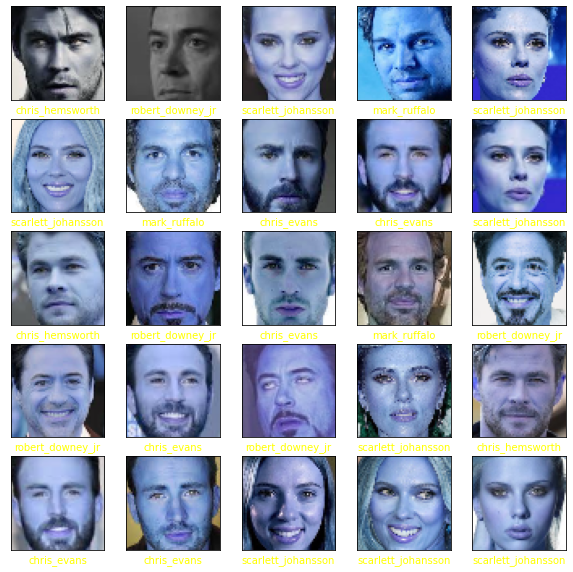

In [76]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(images_shuffled[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=target_names_shuffled[i])
    axi.xaxis.label.set_color('yellow')

<h4>We will use a principal component analysis
to extract 150 fundamental components to feed into our support vector machine classifier</h4>

In [189]:
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

<h4>Let's split the data into a training and testing set:</h4>

In [190]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(images_shuffled, target_shuffled,
                                                random_state=42)

In [191]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain.reshape(205,10092), ytrain) # Reshape array to 2d
print(grid.best_params_)

Wall time: 33 s
{'svc__C': 5, 'svc__gamma': 0.005}


In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest.reshape(69,10092))

<h4>Let's take a look at a few of the test images along with their predicted values:</h4>

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

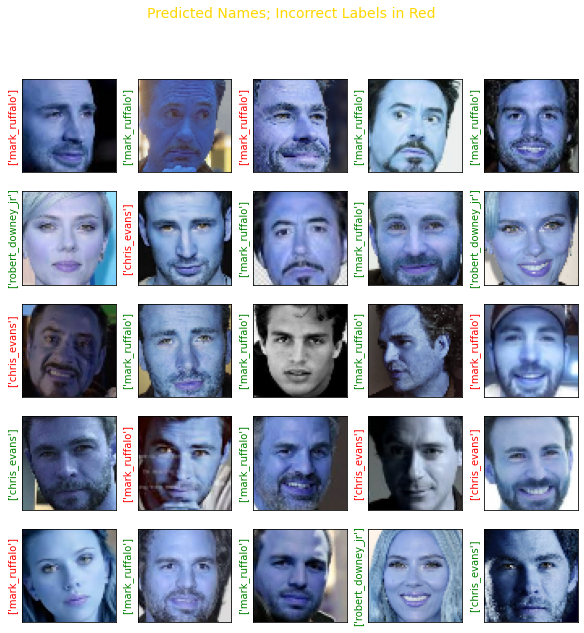

In [198]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i], cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(np.unique(target_names_shuffled[yfit[i]].split()[-1]),
                   color='green' if yfit[i] == ytest[i] else 'red'
                  )
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14, color='gold')

In [194]:
print(classification_report(ytest, yfit,
                            target_names=np.unique(target_names_shuffled)))

                    precision    recall  f1-score   support

       chris_evans       0.92      0.58      0.71        19
   chris_hemsworth       0.50      0.67      0.57        12
      mark_ruffalo       0.70      0.94      0.80        17
  robert_downey_jr       0.80      0.67      0.73        12
scarlett_johansson       1.00      0.89      0.94         9

          accuracy                           0.74        69
         macro avg       0.78      0.75      0.75        69
      weighted avg       0.78      0.74      0.74        69



<h4>Confusion matrix between these classes:</h4>

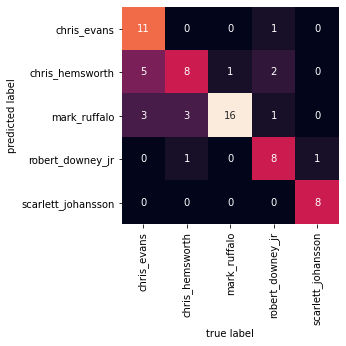

In [202]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(target_names_shuffled),
            yticklabels=np.unique(target_names_shuffled))
plt.xlabel('true label')
plt.ylabel('predicted label');